## Selección de características mediante regresión Lasso, Ridge y Elastic Net

In [5]:
import cvxpy as cp
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [6]:
# Ridge Regression con CVXPY (Versión usando normas)
def ridge_regression_cvxpy(X, y, lambd):
    n_features = X.shape[1]
    beta = cp.Variable(n_features)
    
    # Es equivalente a sum_squares, pero hay que elevar la norma al cuadrado
    # para que sea una regresión Ridge estándar.
    objetivo = cp.Minimize(cp.norm(X @ beta - y, 2)**2 + lambd * cp.norm(beta, 2)**2)
    
    problem = cp.Problem(objetivo)
    problem.solve()
    
    return beta.value

In [7]:
# Lasso Regression con CVXPY usando cp.norm
def lasso_regression_cvxpy(X, y, lambd):
    # 1. Definimos la variable de optimización
    n_features = X.shape[1]
    beta = cp.Variable(n_features)
    
    # 2. Definimos el problema
    # Usamos cp.norm(..., 2)**2 para el error cuadrático (equivalente a sum_squares)
    # Usamos cp.norm(..., 1) para la penalización Lasso (sin elevar al cuadrado)
    objetivo = cp.Minimize(cp.norm(X @ beta - y, 2)**2 + lambd * cp.norm(beta, 1))
    
    # 3. Resolvemos
    problem = cp.Problem(objetivo)
    problem.solve()
    
    return beta.value

In [8]:
import cvxpy as cp

def elastic_net(X, y, lambd=1.0, alpha=0.5):
    """
    Regresión Elastic Net usando CVXPY.
    """
    # Número de muestras y características
    n_samples, n_features = X.shape
    
    # Definir las variables de coeficientes
    beta = cp.Variable(n_features)
    
    # Definir el término de error cuadrático (mínimos cuadrados)
    # Usamos la norma 2 al cuadrado como en los apartados anteriores
    error = cp.norm(X @ beta - y, 2)**2
    
    # Definir los términos de penalización L1 y L2
    penalizacion_L1 = cp.norm(beta, 1)
    penalizacion_L2 = 0.5 * cp.norm(beta, 2)**2
    
    # Función objetivo: minimizar el error + penalización Elastic Net
    # El parámetro alpha controla el balance: 
    # Si alpha=1 es Lasso puro, si alpha=0 es Ridge puro.
    objective = cp.Minimize(error + lambd * (alpha * penalizacion_L1 + (1 - alpha) * penalizacion_L2))
    
    # Definir el problema
    problem = cp.Problem(objective)
    
    # Resolver el problema
    problem.solve()
    
    # Retornar los coeficientes
    return beta.value

In [9]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# 1. Generar datos de ejemplo (Lo que tú me has puesto)
X, y = make_regression(n_samples=100, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Comprobar el funcionamiento de los modelos
# Definimos parámetros para la prueba
lambd_val = 0.5
alpha_val = 0.5

# Llamamos a tus funciones de CVXPY
beta_ridge = ridge_regression_cvxpy(X_train, y_train, lambd_val)
beta_lasso = lasso_regression_cvxpy(X_train, y_train, lambd_val)
beta_elastic = elastic_net(X_train, y_train, lambd=lambd_val, alpha=alpha_val)

# 3. Organizar resultados en un DataFrame para comparar
df_resultados = pd.DataFrame({
    'Característica': [f'F{i}' for i in range(X.shape[1])],
    'Ridge (L2)': beta_ridge,
    'Lasso (L1)': beta_lasso,
    'Elastic Net': beta_elastic
})

print("--- Comparativa de Coeficientes Aprendidos ---")
print(df_resultados)

# 4. Cálculo de Error Cuadrático Medio (MSE) en Test
mse_r = mean_squared_error(y_test, X_test @ beta_ridge)
mse_l = mean_squared_error(y_test, X_test @ beta_lasso)
mse_e = mean_squared_error(y_test, X_test @ beta_elastic)

print(f"\nResultados de Error (MSE):")
print(f"MSE Ridge: {mse_r:.6f}")
print(f"MSE Lasso: {mse_l:.6f}")
print(f"MSE Elastic Net: {mse_e:.6f}")

--- Comparativa de Coeficientes Aprendidos ---
  Característica  Ridge (L2)  Lasso (L1)  Elastic Net
0             F0   16.874932   16.771282    16.798343
1             F1   53.708204   54.138477    54.031033
2             F2    5.155547    5.174561     5.170894
3             F3   63.178524   63.641869    63.526058
4             F4   92.868031   93.607394    93.422583
5             F5   70.182461   70.635955    70.522787
6             F6   86.536536   87.066566    86.934240
7             F7   10.166469   10.432793    10.366907
8             F8    3.211500    3.156223     3.170877
9             F9   70.260813   70.902919    70.742221

Resultados de Error (MSE):
MSE Ridge: 3.037704
MSE Lasso: 0.010893
MSE Elastic Net: 0.219045


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_8065/1265423096.py:10: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


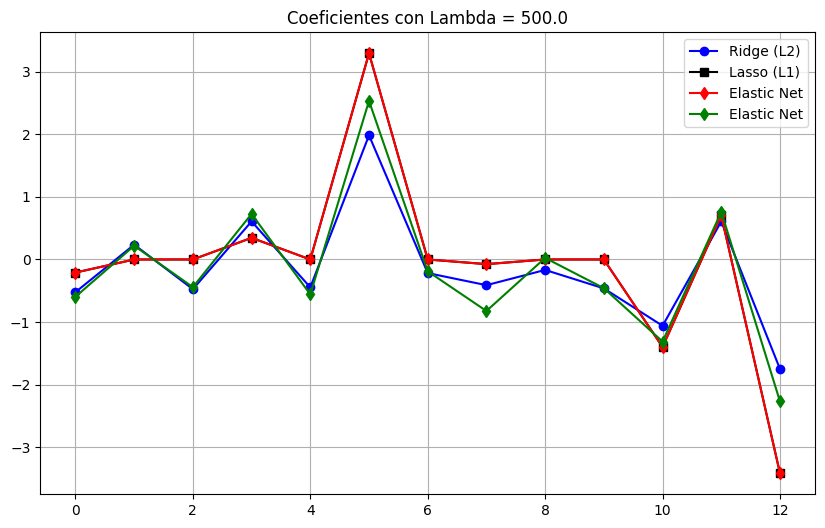

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Cargar y preparar los datos (Corrección de dimensiones)
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

# Boston tiene 13 características. El archivo raw tiene 11 en una fila y 2 en la siguiente.
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

# 1. ESTANDARIZAR (Crucial para ver diferencias en regularización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. USAR UN LAMBDA MÁS ALTO
l_test = 500.0  # Sube este valor si siguen pareciéndose

ridge_beta = ridge_regression_cvxpy(X_train_scaled, y_train, lambd=l_test)
lasso_beta = lasso_regression_cvxpy(X_train_scaled, y_train, lambd=l_test)
elastic_beta = elastic_net(X_train_scaled, y_train, lambd=l_test, alpha=1)
elastic_beta2 = elastic_net(X_train_scaled, y_train, lambd=l_test, alpha=0)

# 3. Graficar de nuevo
plt.figure(figsize=(10, 6))
plt.plot(ridge_beta, 'b-o', label="Ridge (L2)")
plt.plot(lasso_beta, 'k-s', label="Lasso (L1)")
plt.plot(elastic_beta, 'r-d', label="Elastic Net")
plt.plot(elastic_beta2, 'g-d', label="Elastic Net")
plt.title(f"Coeficientes con Lambda = {l_test}")
plt.legend()
plt.grid(True)
plt.show()

/home/jorgetg/Aprendizaje Automatico II/proyecto_Aprendizaje/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


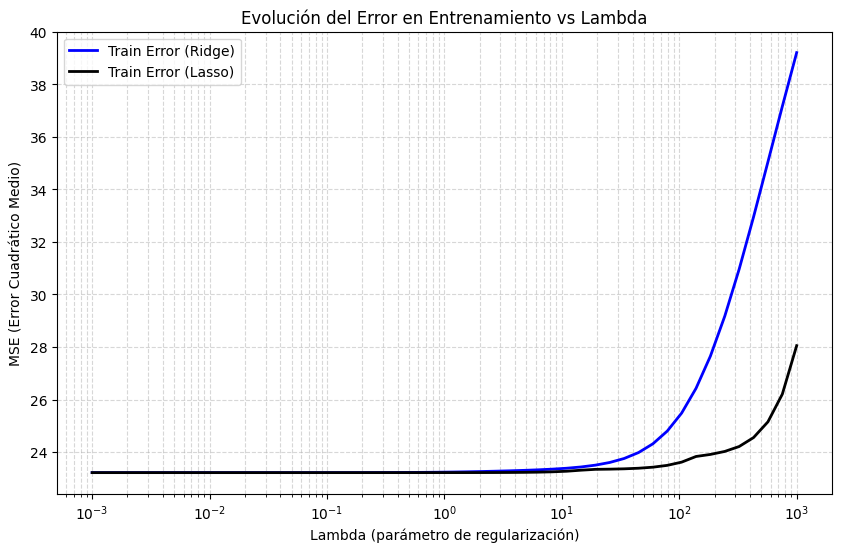

In [11]:
# Evolución del error en train en función de lambda


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1. Definimos un rango de lambdas (desde muy pequeño a muy grande)
lambdas = np.logspace(-3, 3, 50)

train_errors_ridge = []
train_errors_lasso = []

for l in lambdas:
    # Calculamos Ridge con el lambda actual
    beta_r = ridge_regression_cvxpy(X_train, y_train, lambd=l)
    mse_r = mean_squared_error(y_train, X_train @ beta_r)
    train_errors_ridge.append(mse_r)
    
    # Calculamos Lasso con el lambda actual
    beta_l = lasso_regression_cvxpy(X_train, y_train, lambd=l)
    mse_l = mean_squared_error(y_train, X_train @ beta_l)
    train_errors_lasso.append(mse_l)

# 2. Representación gráfica
plt.figure(figsize=(10, 6))
plt.plot(lambdas, train_errors_ridge, label="Train Error (Ridge)", color="blue", lw=2)
plt.plot(lambdas, train_errors_lasso, label="Train Error (Lasso)", color="black", lw=2)

plt.xscale('log') # Escala logarítmica para ver bien el rango de lambdas
plt.xlabel('Lambda (parámetro de regularización)')
plt.ylabel('MSE (Error Cuadrático Medio)')
plt.title('Evolución del Error en Entrenamiento vs Lambda')
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.show()


/home/jorgetg/Aprendizaje Automatico II/proyecto_Aprendizaje/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


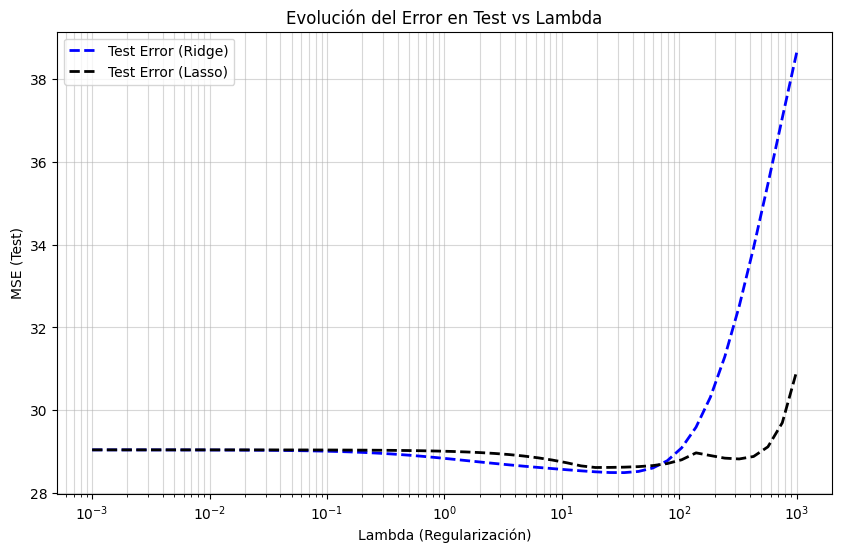

El lambda óptimo para Ridge es: 33.9322


In [12]:
# Evolución del error en test en función de lambda


test_errors_ridge = []
test_errors_lasso = []

for l in lambdas:
    # Evaluación Ridge en Test
    beta_r = ridge_regression_cvxpy(X_train, y_train, lambd=l)
    mse_r_test = mean_squared_error(y_test, X_test @ beta_r)
    test_errors_ridge.append(mse_r_test)
    
    # Evaluación Lasso en Test
    beta_l = lasso_regression_cvxpy(X_train, y_train, lambd=l)
    mse_l_test = mean_squared_error(y_test, X_test @ beta_l)
    test_errors_lasso.append(mse_l_test)

# Representación gráfica
plt.figure(figsize=(10, 6))
plt.plot(lambdas, test_errors_ridge, label="Test Error (Ridge)", color="blue", linestyle='--', lw=2)
plt.plot(lambdas, test_errors_lasso, label="Test Error (Lasso)", color="black", linestyle='--', lw=2)

plt.xscale('log')
plt.xlabel('Lambda (Regularización)')
plt.ylabel('MSE (Test)')
plt.title('Evolución del Error en Test vs Lambda')
plt.legend()
plt.grid(True, which="both", alpha=0.5)
plt.show()

# Encontrar el lambda óptimo (donde el error es mínimo)
opt_lambda_ridge = lambdas[np.argmin(test_errors_ridge)]
print(f"El lambda óptimo para Ridge es: {opt_lambda_ridge:.4f}")
